In [1]:
# !python -m pip install -U spacy
# !python -m pip install -U spacy-lookups-data
# !python -m spacy download pt_core_news_sm
# !python -m pip install -U unidecode
# !python -m pip install -U tensorflow
# !wget http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s100.zip -O glove_s100.zip
# !unzip glove_s100.zip

## Content
    
    The tweets in the dataset were collected from Twitter mainly from 01-08-2018 to 20-10-2018.
    
    Training datasets:
    
    100k positive, negative and neutral tweets without any theme
    
    All of them have an equal number of instances between classes. Their sentiment labels were transformed as follow:
    
    Negative label: 0
    Positive label: 1
    Neutral  label: 2

## Import useful libraries and modules

In [2]:
import random
import re
import string
from unidecode import unidecode

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import RSLPStemmer
from nltk.stem.snowball import PortugueseStemmer

import spacy
from spacy.lang.pt import Portuguese

from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from pprint import pprint
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

# NLTK downloads
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Me\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Me\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

## Loading the data and performing exploratory data analyses

In [3]:
data = pd.read_csv('./Train3Classes.csv', sep=';', usecols=['tweet_text', 'sentiment'])

# Label the target classes
data['sentiment'] = data['sentiment'].map({0: 'negative', 1: 'positive', 2: 'neutral'})

In [4]:
data.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o vale e azevedo :),positive
1,"@behin_d_curtain Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)",positive
2,Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina https://t.co/5RjhKnj0oh Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional :D,positive
3,"aaaaaaaa amei tanto essas polaroids, nem sei expressar o quanto eu to apaixonada de vdd✨💖🎈🎉🎊 espero que outras pessoas consigam ganhar também :) https://t.co/pbIp7tRcSE",positive
4,"Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele :)) https://t.co/5c7wlXQyz9",positive


In [5]:
print(f'This dataset has {data.shape[0]} rows and {data.shape[1]} columns')

This dataset has 100000 rows and 2 columns


In [6]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   tweet_text  100000 non-null  object
 1   sentiment   100000 non-null  object
dtypes: object(2)
memory usage: 25.0 MB


## Exploring target distribution

In [7]:
data['sentiment'].value_counts(dropna=False)

positive    33334
neutral     33333
negative    33333
Name: sentiment, dtype: int64

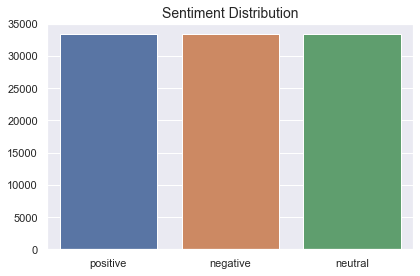

In [8]:
# Plot the sentiment distribution
sns.set()
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution', fontsize=14)
plt.ylabel(None); plt.xlabel(None)
plt.tight_layout();

## Preprocessing the raw data

* Removing urls, hashtags, emails
* Removing numbers
* Tokenizing sentences
* Removing handles
* Transforming accented words
* Removing unicode characters
* Lowercasing
* Removing stop words, punctuation
* Lemmatization, stemming

In [9]:
# Regular expressions
remove_urls     = re.compile(r'https?://\S+|www\.\S+')
remove_hashtags = re.compile(r'#')
remove_emails   = re.compile(r'\S+@\S+')
remove_rt       = re.compile(r'^RT[\s]+')
remove_numbers  = re.compile(r'\d+')

### Prepare stop words ###
# Load Kaggle stop words
with open('./portugueseST.txt', 'r', encoding='latin-1') as words:
    kaggle_stop_words = [word.strip() for word in words]

# Load NLTK stop words
nltk_stop_words  = stopwords.words('portuguese')

# Load SpaCy stop words
spacy_stop_words = list(spacy.lang.pt.STOP_WORDS)

# Custom stop words
custom_stop_words = ['pra', 'to', 'vc', 'tá', 'pq', 'tô', 'ta', 'mt', 'pro',
                     'né', 'eh', 'tbm', 'ja', 'ah', 'vcs', 'hj', 'so',  'mto',
                     'agr', 'oq', 'la', 'tou', 'td', 'voce', 'ne', 'obg', 'tb']

# Portuguese stop words
portuguese_stop_words = []
portuguese_stop_words.extend(kaggle_stop_words)
portuguese_stop_words.extend(nltk_stop_words)
portuguese_stop_words.extend(spacy_stop_words)
portuguese_stop_words.extend(custom_stop_words)
no_accented_stop_words = [unidecode(word) for word in portuguese_stop_words]
portuguese_stop_words.extend(no_accented_stop_words)
portuguese_stop_words.sort()
portuguese_stop_words = set(portuguese_stop_words)

# Load punctuation
punctuation = string.punctuation

# Instantiate TweetTokenizer
tt = TweetTokenizer(preserve_case=False, # lowercasing
                    strip_handles=True,  # remove handles
                    reduce_len=True)     

def preprocess_text(text):

    # Parse HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    ## Apply regex
    text = remove_urls.sub('', text)        # remove urls
    text = remove_hashtags.sub('', text)    # remove hashtags    
    text = remove_emails.sub('', text)      # remove emails
    text = remove_rt.sub('', text)          # remove RT
    text = remove_numbers.sub('', text)     # remove numbers 

    # Tokenize, lowercase, remove handles
    tokens = tt.tokenize(text)

    # Remove punctuation
    tokens = [word for word in tokens if word not in punctuation]

    # Transform accented words
    tokens = [unidecode(word) if word.isalpha() else word for word in tokens]

    # Remove unicode characters
    tokens = [word.encode('ascii', 'ignore').decode() for word in tokens]
    
    # Remove stop words    
    tokens = [word for word in tokens if word not in portuguese_stop_words]

    # Remove no alphabetical and single chars
    tokens = [word for word in tokens if word.isalpha() and len(word) > 1]

    ## NLTK SnowBall Portuguese stemmer
    # st = PortugueseStemmer()
    # tokens = [st.stem(word) for word in tokens]

    ## NLTK RSLPStemmer Portuguese stemmer
    # st = RSLPStemmer()
    # tokens = [st.stem(word) for word in tokens]
    
    ### SpaCy ###
    ## Lemmatization
    # text = ' '.join(tokens)
    # doc = nlp(text)
    
    # tokens = [token.lemma_ for token in doc if token.lemma_ not in portuguese_stop_words]
    
    return ' '.join(tokens)

In [11]:
%%time
# Preprocess data
data['text'] = data['tweet_text'].apply(preprocess_text)

Wall time: 28 s


In [12]:
data.head()

,tweet_text,sentiment,text
0,@Laranjito76 A pessoa certa para isso seria o vale e azevedo :),positive,pessoa certa vale azevedo
1,"@behin_d_curtain Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)",positive,mim precisamente contrario chuva disposicao
2,Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina https://t.co/5RjhKnj0oh Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional :D,positive,vou video pensando falar meta csgo pagina alguem sugestao queria falar cenario nacional
3,"aaaaaaaa amei tanto essas polaroids, nem sei expressar o quanto eu to apaixonada de vdd✨💖🎈🎉🎊 espero que outras pessoas consigam ganhar também :) https://t.co/pbIp7tRcSE",positive,aaa amei polaroids expressar apaixonada vdd espero pessoas consigam ganhar
4,"Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele :)) https://t.co/5c7wlXQyz9",positive,valoriza coracao menininho diferente faca sorrir valorizo mundo vida diferente


## Handling missing data

In [13]:
# Creat a "word count" column from the preprocessed text
data['word_count'] = data['text'].apply(lambda row: len(row.split()))
display(data.loc[data['word_count'] == 0].head())

,tweet_text,sentiment,text,word_count
47,@claaract_ De nada! :),positive,,0
58,@WeLovesT3ddy Obrigada!!! :),positive,,0
62,Está tudo bem :),positive,,0
75,NÃO FAÇO MAIS QUESTÃO :),positive,,0
81,@animal_slb @EPlurCorruptum @xiquinhorabeta @HugoGil07 @boloposte Nem mais :),positive,,0


In [14]:
data.loc[data['word_count'] == 0, ['text']] = np.nan
print(data.isna().sum())

tweet_text       0
sentiment        0
text          2454
word_count       0
dtype: int64


In [15]:
data.dropna(inplace=True)
print(data.isna().sum())
print('---')
print(data.shape)

tweet_text    0
sentiment     0
text          0
word_count    0
dtype: int64
---
(97546, 4)


In [16]:
print(f'This dataset has {data.shape[0]} rows and {data.shape[1]} columns after the data cleaning.')
print('---\n')

# Compute words frequency
text = ' '.join(data['text'])
freq_dist = nltk.FreqDist(TweetTokenizer().tokenize(text))

# Compute rare words
rare_words = [word for word, freq in freq_dist.items() if freq == 1]

print(f'This dataset has {len(freq_dist)} unique words and {len(rare_words)} rare words')
print('---\n')
# Show the thirty five most common words
pprint(freq_dist.most_common(35), compact=True)

This dataset has 97546 rows and 4 columns after the data cleaning.
---

This dataset has 59715 unique words and 29918 rare words
---

[('fato', 3862), ('vou', 3587), ('bolsonaro', 3534), ('queria', 3067),
 ('oportunidade', 2854), ('gente', 2378), ('eleicoes', 2151), ('emprego', 2108),
 ('triste', 2028), ('amo', 1892), ('brasil', 1860), ('vaga', 1782),
 ('sp', 1627), ('haddad', 1593), ('vida', 1539), ('melhor', 1530),
 ('pessoas', 1510), ('noticia', 1421), ('acho', 1390), ('mim', 1365),
 ('mundo', 1355), ('feliz', 1313), ('amor', 1313), ('casa', 1280),
 ('kkk', 1238), ('ficar', 1223), ('ciro', 1165), ('semana', 1157),
 ('turno', 1153), ('alguem', 1125), ('fake', 1123), ('novidade', 1103),
 ('pt', 1099), ('paulo', 1091), ('deus', 1052)]


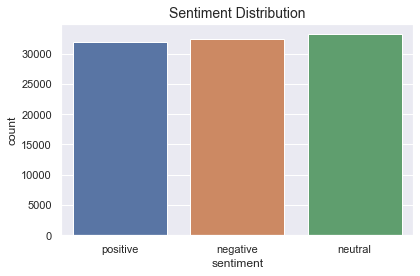

In [17]:
# Plot the target distribution after cleaning data
sns.set()
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution', fontsize=14)
plt.tight_layout();

## Preparing data

In [18]:
data_reduced = data.loc[data['word_count'] > 4]
print(data_reduced.shape)

(57947, 4)


In [19]:
# X = data.loc[:, ['text', 'word_count']]
# y = data['sentiment'].values

X = data_reduced.loc[:, ['text', 'word_count']]
y = data_reduced['sentiment'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((46357, 2), (46357,), (11590, 2), (11590,))

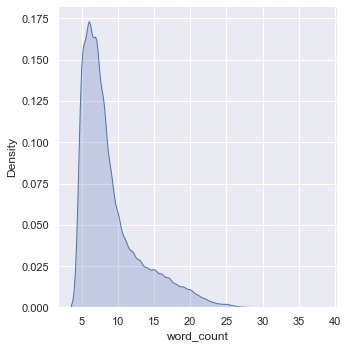

In [21]:
# # Updata the "word_count" column
data['word_count'] = data['text'].apply(lambda row: len(row.split()))

sns.set()
bins=len(set(X_train['word_count']))
sns.displot(x='word_count', data=X_train, kind='kde', fill=True) 
# sns.displot(x='word_count', data=X_train, bins=bins)
plt.tight_layout();

## Transforming text into vectors

In [22]:
params = {
    'tokenizer': {'num_words': None, 'oov_token': '<UNK>'},
    'pad_sequences': {'maxlen': 30, 'padding': 'post', 'truncating': 'post'},
}

tokenize = Tokenizer(**params['tokenizer'])
tokenize.fit_on_texts(X_train['text'])
word_index = tokenize.word_index

X_train_seq = tokenize.texts_to_sequences(X_train['text'])
X_train_pad = pad_sequences(X_train_seq, **params['pad_sequences'])

X_test_seq  = tokenize.texts_to_sequences(X_test['text'])
X_test_pad  = pad_sequences(X_test_seq, **params['pad_sequences'])

## Preparing labels

In [23]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)

target_names = le.classes_

In [24]:
# Sanity check
print(X_train_pad.shape, y_train.shape, X_test_pad.shape, y_test.shape, target_names)

(46357, 30) (46357,) (11590, 30) (11590,) ['negative' 'neutral' 'positive']


## Training and validating the model

In [26]:
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
tf.keras.backend.clear_session()

vocab_size =  len(word_index) + 1
embedding_dim = 128

classifier = tf.keras.models.Sequential([
             tf.keras.layers.Embedding(vocab_size,
                                       embedding_dim, 
                                       input_length=X_train_pad.shape[1]),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.4, recurrent_dropout=0.4)),
             tf.keras.layers.Dense(64, activation='relu'),
             tf.keras.layers.Dense(3, activation='softmax'),
])

lr = 1e-2
classifier.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 128)           6159616   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 256)           263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 6,833,667
Trainable params: 6,833,667
Non-trainable params: 0
_________________________________________________________________


In [25]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau('val_accuracy',    
                                         patience=4,
                                         factor=0.5,
                                         mode='max',
                                         verbose=1),

    tf.keras.callbacks.EarlyStopping('val_accuracy', 
                                     patience=10,
                                     verbose=1,
                                     mode='max',
                                     restore_best_weights=True),
]

In [27]:
%%time
history = classifier.fit(X_train_pad,
                         y_train,
                         batch_size=64, 
                         epochs=100, 
                         validation_split=0.2, 
                         callbacks=callbacks, 
                         workers=4, 
                         use_multiprocessing=True);

Train on 37085 samples, validate on 9272 samples
Epoch 1/100
37085/37085 [==============================] - 152s 4ms/sample - loss: 0.5243 - accuracy: 0.7641 - val_loss: 0.4364 - val_accuracy: 0.8073
Epoch 2/100
37085/37085 [==============================] - 142s 4ms/sample - loss: 0.2976 - accuracy: 0.8794 - val_loss: 0.4576 - val_accuracy: 0.8231
Epoch 3/100
37085/37085 [==============================] - 144s 4ms/sample - loss: 0.1957 - accuracy: 0.9286 - val_loss: 0.5635 - val_accuracy: 0.8127
Epoch 4/100
37085/37085 [==============================] - 142s 4ms/sample - loss: 0.1554 - accuracy: 0.9441 - val_loss: 0.5995 - val_accuracy: 0.8116
Epoch 5/100
37085/37085 [==============================] - 144s 4ms/sample - loss: 0.1386 - accuracy: 0.9515 - val_loss: 0.5992 - val_accuracy: 0.8007
Epoch 6/100
37056/37085 [============================>.] - ETA: 0s - loss: 0.1592 - accuracy: 0.9440
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
37085/37085 [===

In [28]:
hist = pd.DataFrame(history.history)

## Plotting the results

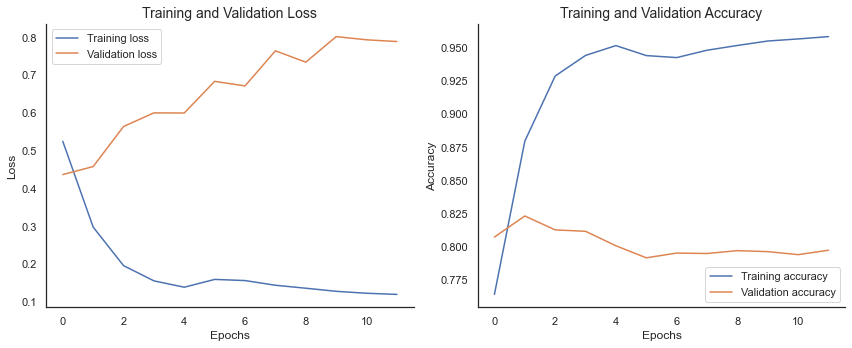

In [29]:
sns.set(style='white')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(x=hist.index, y='loss', data=hist, label='Training loss', ax=ax[0])
sns.lineplot(x=hist.index, y='val_loss', data=hist, label='Validation loss', ax=ax[0])

ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].set_title('Training and Validation Loss', fontsize=14)

sns.lineplot(x=hist.index, y='accuracy', data=hist, label='Training accuracy', ax=ax[1])

sns.lineplot(x=hist.index, y='val_accuracy', data=hist, label='Validation accuracy', ax=ax[1])

ax[1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1].set_title('Training and Validation Accuracy', fontsize=14)

sns.despine()             
plt.tight_layout();

## Evaluating the model

In [30]:
_, accuracy = classifier.evaluate(X_test_pad, y_test, batch_size=1024, verbose=0)
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 82.64%


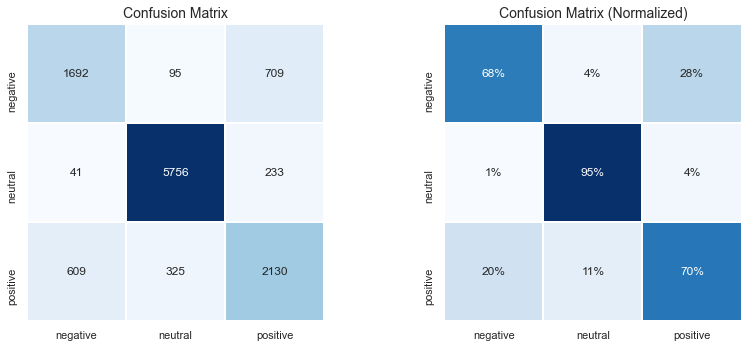

In [31]:
preds = np.argmax(classifier.predict(X_test_pad, batch_size=1024), axis=1)


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, preds),
            cmap='Blues',
            center=None,
            annot=True,
            fmt='d',
            linewidths=1,
            cbar=False,
            square=True,
            xticklabels=target_names,
            yticklabels=target_names,
            ax=ax[0])
            
ax[0].set_title('Confusion Matrix', fontsize=14)    

sns.heatmap(confusion_matrix(y_test, preds, normalize='true'),
            cmap='Blues',
            center=None,
            annot=True,
            fmt='.0%',
            linewidths=1,
            cbar=False,
            square=True,
            xticklabels=target_names,
            yticklabels=target_names,
            ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized)', fontsize=14) 

plt.tight_layout();

In [32]:
print(classification_report(y_test, preds, target_names=target_names));

              precision    recall  f1-score   support

    negative       0.72      0.68      0.70      2496
     neutral       0.93      0.95      0.94      6030
    positive       0.69      0.70      0.69      3064

    accuracy                           0.83     11590
   macro avg       0.78      0.78      0.78     11590
weighted avg       0.82      0.83      0.82     11590



# Using a pretrained GloVe word embeddings
---

## Preprocessing the embeddings

In [33]:
%%time
# Parse the GloVe word-embeddings file
glove_model = KeyedVectors.load_word2vec_format('./glove_s100.txt')
print(f'Found {len(glove_model.vocab)} word vectors.')
print('---\n')

# Prepare the GloVe word-embeddings matrix
vocab_size = len(word_index) + 1
embedding_dim = 100

embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in glove_model:
        embeddings_matrix[i] = glove_model[word]

print(f'Embeddings matrix dimensions: {embeddings_matrix.shape[0]} rows and {embeddings_matrix.shape[1]} columns')

Found 929605 word vectors.
---

Embeddings matrix dimensions: 48122 rows and 100 columns
Wall time: 1min 58s


## Training the model with a pretrained word embeddings

In [34]:
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
tf.keras.backend.clear_session()

classifier = tf.keras.models.Sequential([
             tf.keras.layers.Embedding(vocab_size,
                                       embedding_dim, 
                                       weights=[embeddings_matrix], trainable=False,
                                       input_length=X_train_pad.shape[1]),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
             tf.keras.layers.Dense(32, activation='relu'),
             tf.keras.layers.Dense(3, activation='softmax'),
])

lr = 1e-2
classifier.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           4812200   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 200)           160800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 5,220,331
Trainable params: 408,131
Non-trainable params: 4,812,200
_________________________________________________________________


In [35]:
%%time
history = classifier.fit(X_train_pad,
                         y_train,
                         batch_size=64, 
                         epochs=100, 
                         validation_split=0.2, 
                         callbacks=callbacks, 
                         workers=4, 
                         use_multiprocessing=True);

Train on 37085 samples, validate on 9272 samples
Epoch 1/100
37085/37085 [==============================] - 68s 2ms/sample - loss: 0.5501 - accuracy: 0.7537 - val_loss: 0.4614 - val_accuracy: 0.7951
Epoch 2/100
37085/37085 [==============================] - 55s 1ms/sample - loss: 0.4431 - accuracy: 0.8028 - val_loss: 0.4341 - val_accuracy: 0.8169
Epoch 3/100
37085/37085 [==============================] - 54s 1ms/sample - loss: 0.4076 - accuracy: 0.8195 - val_loss: 0.4304 - val_accuracy: 0.8171
Epoch 4/100
37085/37085 [==============================] - 56s 1ms/sample - loss: 0.3961 - accuracy: 0.8265 - val_loss: 0.4286 - val_accuracy: 0.8215
Epoch 5/100
37085/37085 [==============================] - 55s 1ms/sample - loss: 0.3853 - accuracy: 0.8291 - val_loss: 0.4295 - val_accuracy: 0.8224
Epoch 6/100
37085/37085 [==============================] - 55s 1ms/sample - loss: 0.3764 - accuracy: 0.8346 - val_loss: 0.4265 - val_accuracy: 0.8209
Epoch 7/100
37085/37085 [==========================

## Plotting the results

In [36]:
hist = pd.DataFrame(history.history)

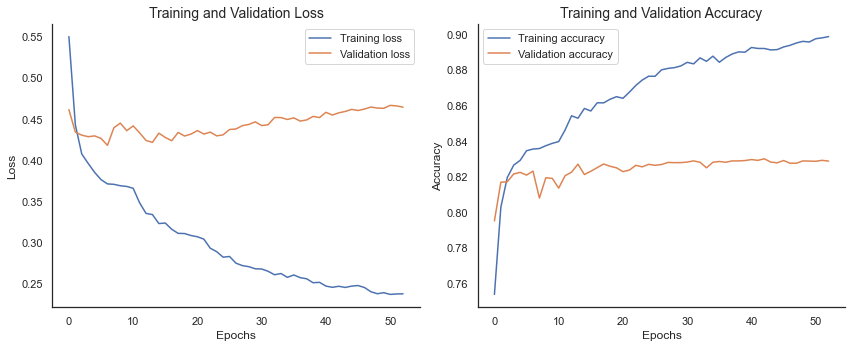

In [37]:
sns.set(style='white')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(x=hist.index, y='loss', data=hist, label='Training loss', ax=ax[0])
sns.lineplot(x=hist.index, y='val_loss', data=hist, label='Validation loss', ax=ax[0])

ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].set_title('Training and Validation Loss', fontsize=14)

sns.lineplot(x=hist.index, y='accuracy', data=hist, label='Training accuracy', ax=ax[1])

sns.lineplot(x=hist.index, y='val_accuracy', data=hist, label='Validation accuracy', ax=ax[1])

ax[1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1].set_title('Training and Validation Accuracy', fontsize=14)

sns.despine()             
plt.tight_layout();

## Evaluating the model

In [38]:
_, accuracy = classifier.evaluate(X_test_pad, y_test, batch_size=1024, verbose=0)
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 83.24%


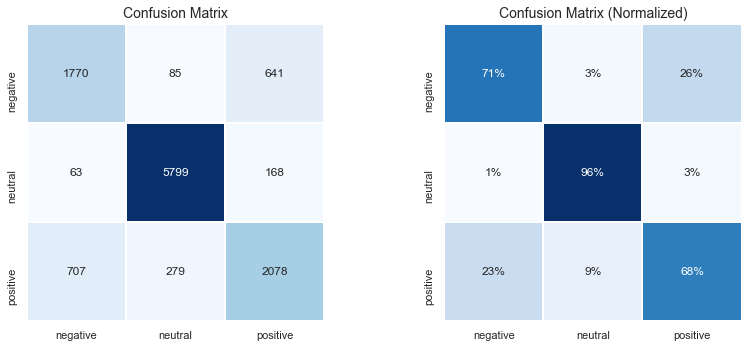

In [39]:
preds = np.argmax(classifier.predict(X_test_pad, batch_size=1024), axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, preds),
            cmap='Blues',
            center=None,
            annot=True,
            fmt='d',
            linewidths=1,
            cbar=False,
            square=True,
            xticklabels=target_names,
            yticklabels=target_names,
            ax=ax[0])
ax[0].set_title('Confusion Matrix', fontsize=14)    

sns.heatmap(confusion_matrix(y_test, preds, normalize='true'),
            cmap='Blues',
            center=None,
            annot=True,
            fmt='.0%',
            linewidths=1,
            cbar=False,
            square=True,
            xticklabels=target_names,
            yticklabels=target_names,
            ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized)', fontsize=14) 

plt.tight_layout();

In [40]:
print(classification_report(y_test, preds, target_names=target_names));

              precision    recall  f1-score   support

    negative       0.70      0.71      0.70      2496
     neutral       0.94      0.96      0.95      6030
    positive       0.72      0.68      0.70      3064

    accuracy                           0.83     11590
   macro avg       0.79      0.78      0.78     11590
weighted avg       0.83      0.83      0.83     11590



References:   

[BI MASTER (MBA) - Business Intelligence Master - Sistemas Inteligentes de Apoio à Decisão em Negócios](http://www.cce.puc-rio.br/sitecce/website/website.dll/folder?nCurso=bi-master-(traco)-business-intelligence-master-(traco)-sistemas-inteligentes-de-apoio-a-decisao-em-negocios&nInst=cce)  
[Natural Language Processing with Classification and Vector Spaces](https://www.coursera.org/learn/classification-vector-spaces-in-nlp/home/welcome)   
[Natural Language Processing in TensorFlow](https://www.coursera.org/learn/natural-language-processing-tensorflow/home/welcome)   
[Reproducible Results With Keras](https://deeplizard.com/learn/video/HcW0DeWRggs)   
[Text Wrangling & Pre-processing: A Practitioner’s Guide to NLP](https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html)    
[20+ POPULAR NLP TEXT PREPROCESSING TECHNIQUES IMPLEMENTATION IN PYTHON](https://dataaspirant.com/nlp-text-preprocessing-techniques-implementation-python/#t-1600081660727)